# Analysing monthly mean temperature using timeseries analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as pyplot

In [2]:
data=pd.read_csv("monthly-mean-temp.csv")

In [3]:
data

,Month,Temperature
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1
...,...,...
235,1939-08,61.8
236,1939-09,58.2
237,1939-10,46.7
238,1939-11,46.6


In [4]:
data.head()

,Month,Temperature
0,1920-01,40.6
1,1920-02,40.8
2,1920-03,44.4
3,1920-04,46.7
4,1920-05,54.1


In [5]:
data.tail()

,Month,Temperature
235,1939-08,61.8
236,1939-09,58.2
237,1939-10,46.7
238,1939-11,46.6
239,1939-12,37.8


# Basic checks

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Month        240 non-null    object 
 1   Temperature  240 non-null    float64
dtypes: float64(1), object(1)
memory usage: 3.9+ KB


In [7]:
data=pd.read_csv('monthly-mean-temp.csv',parse_dates=[0],index_col='Month')

In [8]:
data.rename(columns={"Temperature":"temp"},inplace=True)

In [9]:
data.head()

,temp
Month,
1920-01-01,40.6
1920-02-01,40.8
1920-03-01,44.4
1920-04-01,46.7
1920-05-01,54.1


In [10]:
data.describe()

,temp
count,240.000000
mean,49.041250
std,8.569705
min,31.300000
25%,41.550000
50%,47.350000
75%,57.000000
max,66.500000


In [11]:
data.isnull().sum()

temp    0
dtype: int64

 No null values present in data

In [12]:
data.shape

(240, 1)

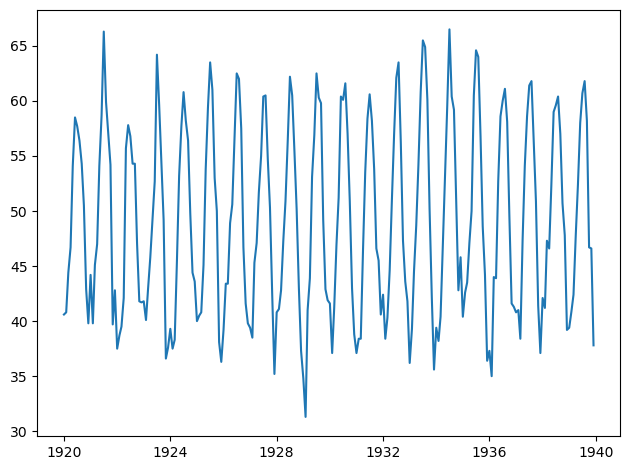

In [13]:
import matplotlib.pyplot as plt
plt.plot(data)
plt.tight_layout()
plt.show()

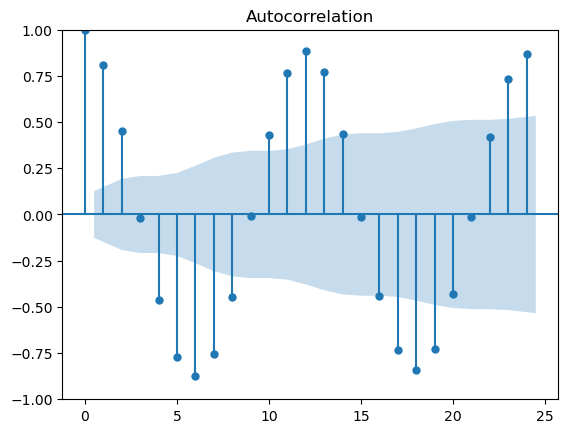

In [14]:
## Plotting the autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data)
plt.show()

From the autocorrelation plot, it is clear that given series is stationary.

In [15]:
# ADfuller Test to check stationarity
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(data.temp, autolag = 'AIC')
print(dftest)
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])


(-3.2554924030863446, 0.016989030222608236, 14, 225, {'1%': -3.4597521044060353, '5%': -2.874472927517147, '10%': -2.5736628197530864}, 1076.9409941126798)
1. ADF :  -3.2554924030863446
2. P-Value :  0.016989030222608236
3. Num Of Lags :  14
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 225


Here we can see that p value is less than 0.05 so our data is stationary.

In [16]:
data.shape

(240, 1)

In [17]:
## Creating training and test sets
train=data[:140] # traning data
test=data[140:] # testing data

In [18]:
test.shape

(100, 1)

In [19]:
train.shape

(140, 1)

In [20]:
 ! pip install statsmodels

In [21]:
import warnings
warnings.filterwarnings("ignore")

# ARMA

In [22]:
from statsmodels.tsa.ar_model import AutoReg

In [23]:
# to select the optimal values for lags
from statsmodels.tsa.ar_model import ar_select_order
mod = ar_select_order(data,maxlag=15,glob=True)
mod.ar_lags

[1, 4, 11, 13]

In [24]:
## model creation
ar_model=AutoReg(train,lags=[1, 4, 11, 13]) ## object creation with lags specified
ar_model_fit=ar_model.fit() #training the model

In [25]:
##making prediction
prediction=ar_model_fit.predict(start=141,end=240) 

In [26]:
prediction.head()

1931-10-01    49.933904
1931-11-01    44.022989
1931-12-01    39.421711
1932-01-01    37.235948
1932-02-01    37.041710
Freq: MS, dtype: float64

In [27]:
test.head()

,temp
Month,
1931-09-01,53.8
1931-10-01,46.6
1931-11-01,45.5
1931-12-01,40.6
1932-01-01,42.4


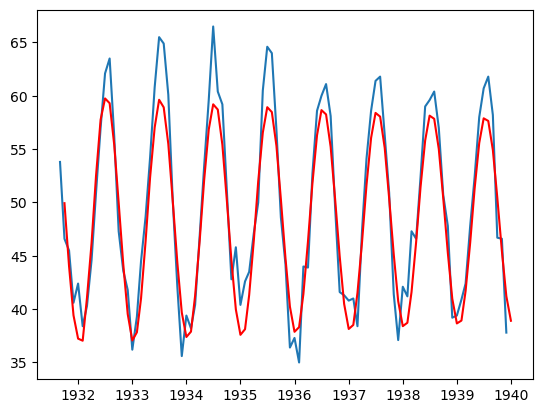

In [28]:
import matplotlib.pyplot as plt
plt.plot(test)
plt.plot(prediction,color="red")
plt.show()

In [29]:
print("test length:", len(test))
print("prediction length:", len(prediction))

test length: 100
prediction length: 100


# ARIMA Model

In [31]:
## importing the library
from statsmodels.tsa.arima.model import ARIMA

In [48]:
##Model object creation and fitting the model
model_arima = ARIMA(train, order=(1, 4, 2))#order=p,d,q
model_arima_fit = model_arima.fit()#training

In [49]:
## evaluate the model
print(model_arima_fit.aic)

857.6919529631275


In [50]:
predictions = model_arima_fit.forecast(steps=9)

In [51]:
prediction

1931-10-01    49.933904
1931-11-01    44.022989
1931-12-01    39.421711
1932-01-01    37.235948
1932-02-01    37.041710
                ...    
1939-09-01    54.921961
1939-10-01    50.453346
1939-11-01    45.438485
1939-12-01    41.216653
1940-01-01    38.910626
Freq: MS, Length: 100, dtype: float64

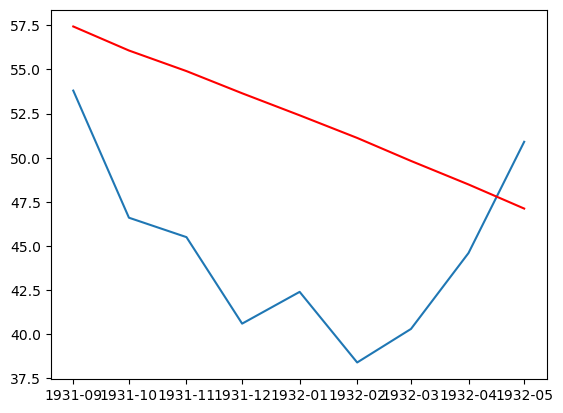

In [52]:
plt.plot(test[:9])
plt.plot(predictions,color='red')
plt.show()

In [53]:
import itertools

p =d= q= range(0,5)#values of p,d,q range from 0 to 4

pdq = list(itertools.product(p,d,q))
print(pdq, len(pdq)) #number of combinaton of pdq

[(0, 0, 0), (0, 0, 1), (0, 0, 2), (0, 0, 3), (0, 0, 4), (0, 1, 0), (0, 1, 1), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 0), (0, 2, 1), (0, 2, 2), (0, 2, 3), (0, 2, 4), (0, 3, 0), (0, 3, 1), (0, 3, 2), (0, 3, 3), (0, 3, 4), (0, 4, 0), (0, 4, 1), (0, 4, 2), (0, 4, 3), (0, 4, 4), (1, 0, 0), (1, 0, 1), (1, 0, 2), (1, 0, 3), (1, 0, 4), (1, 1, 0), (1, 1, 1), (1, 1, 2), (1, 1, 3), (1, 1, 4), (1, 2, 0), (1, 2, 1), (1, 2, 2), (1, 2, 3), (1, 2, 4), (1, 3, 0), (1, 3, 1), (1, 3, 2), (1, 3, 3), (1, 3, 4), (1, 4, 0), (1, 4, 1), (1, 4, 2), (1, 4, 3), (1, 4, 4), (2, 0, 0), (2, 0, 1), (2, 0, 2), (2, 0, 3), (2, 0, 4), (2, 1, 0), (2, 1, 1), (2, 1, 2), (2, 1, 3), (2, 1, 4), (2, 2, 0), (2, 2, 1), (2, 2, 2), (2, 2, 3), (2, 2, 4), (2, 3, 0), (2, 3, 1), (2, 3, 2), (2, 3, 3), (2, 3, 4), (2, 4, 0), (2, 4, 1), (2, 4, 2), (2, 4, 3), (2, 4, 4), (3, 0, 0), (3, 0, 1), (3, 0, 2), (3, 0, 3), (3, 0, 4), (3, 1, 0), (3, 1, 1), (3, 1, 2), (3, 1, 3), (3, 1, 4), (3, 2, 0), (3, 2, 1), (3, 2, 2), (3, 2, 3), (3, 2, 4), (3, 3, 0)

In [54]:
list1=[]
list2=[]
for params in pdq: #iterating params over pdq
    try:
        model_arima = ARIMA(train, order=params)#training model on various pdq values
        model_arima_fit = model_arima.fit()#training
        print(params, model_arima_fit.aic)#printing parameter and aic values
        list1.append(params)
        list2.append(model_arima_fit.aic)
    except:
        continue

(0, 0, 0) 997.8270139079556
(0, 0, 1) 889.2809193835585
(0, 0, 2) 842.359881323744
(0, 0, 3) 810.1657094282912
(0, 0, 4) 797.9844275196351
(0, 1, 0) 853.230012093592
(0, 1, 1) 835.5372653909756
(0, 1, 2) 823.7853083065006
(0, 1, 3) 817.1286641155025
(0, 1, 4) 818.9293140902657
(0, 2, 0) 865.4790656974967
(0, 2, 1) 849.8222409503019
(0, 2, 2) 848.2786686961026
(0, 2, 3) 824.8323968982901
(0, 2, 4) 817.811103547954
(0, 3, 0) 997.8372475168607
(0, 3, 1) 867.1444316925998
(0, 3, 2) 852.4278669850557
(0, 3, 3) 850.3277999680247
(0, 3, 4) 831.6245889949795
(0, 4, 0) 1156.9477406875803
(0, 4, 1) 998.4775504634674
(0, 4, 2) 873.9043407129129
(0, 4, 3) 860.5983782836024
(0, 4, 4) 857.8252107864298
(1, 0, 0) 850.646970130719
(1, 0, 1) 826.6814345283962
(1, 0, 2) 810.8877134016614
(1, 0, 3) 797.4417015275473
(1, 0, 4) 799.1866381529333
(1, 1, 0) 826.6552668072891
(1, 1, 1) 827.7754412217816
(1, 1, 2) 823.5826640620888
(1, 1, 3) 807.8337493490835
(1, 1, 4) 794.459928649997
(1, 2, 0) 847.2366854083

In [55]:
min(list2)  # lowest aic score

675.6537962221241

In [56]:
list2.index(min(list2))

53

In [57]:
# pdq corresponding to lowest aic
loc=list2.index(min(list2))
list1[loc]

(2, 0, 3)

In [58]:
## create the final model with lowest aic score parameter
model_arima = ARIMA(train, order=(2,0,3))
model_arima_fit = model_arima.fit() #training

In [59]:
print(model_arima_fit.aic) # confirm aic score

675.6537962221241


In [60]:
forecast = model_arima_fit.forecast(steps=9)
forecast

1931-09-01    55.438785
1931-10-01    50.386336
1931-11-01    44.588690
1931-12-01    39.886080
1932-01-01    37.534667
1932-02-01    38.162558
1932-03-01    41.602021
1932-04-01    46.934294
1932-05-01    52.735010
Freq: MS, Name: predicted_mean, dtype: float64

In [61]:
forecast25 = model_arima_fit.forecast(steps=25)
test1 = test[0:25].values.flatten()
test1

array([53.8, 46.6, 45.5, 40.6, 42.4, 38.4, 40.3, 44.6, 50.9, 57. , 62.1,
       63.5, 56.2, 47.3, 43.6, 41.8, 36.2, 39.3, 44.5, 48.7, 54.2, 60.8,
       65.5, 64.9, 60.1])

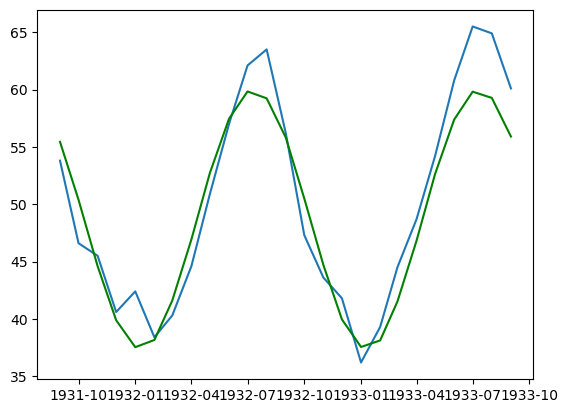

In [62]:
# Comparision of actual vs predicted for 25 values
plt.plot(test[:25])
plt.plot(forecast25,color='green') #line plot for prediction
plt.show()

In [63]:
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tools.eval_measures import rmse

# Calculate root mean squared error
print('RMSE',rmse(test1, forecast25))

# Calculate mean squared error
print('MSE',mean_squared_error(test1, forecast25))

print('MAE',mean_absolute_error(test1,forecast25))


RMSE 2.8460306946462373
MSE 8.099890714868543
MAE 2.3606351382881186


- Higher RMSE than MAE suggests some larger individual errors may exist—maybe from months with unusual climate behavior or poor seasonal fit.
- Since temperature data tends to be seasonal and cyclic, residuals might reflect seasonal lags or mismatches.

